In [ ]:
import os
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
from rtsi import RTSI

In [8]:
dir = os.getcwd()
size = 10

win_length = 640
hop_length = 128
rtsi = RTSI(win_length=win_length, hop_length=hop_length)
def load_dataset():
    male_voice_path = os.path.join(dir, 'dataset/male_voices')
    male_voice_names = [pos_file for pos_file in os.listdir(male_voice_path)]
    female_voice_path = os.path.join(dir, 'dataset/female_voices')
    female_voice_names = [pos_file for pos_file in os.listdir(female_voice_path)]
    data_x = []
    data_y = []
    for (female_voice_name, male_voice_name) in zip(female_voice_names, male_voice_names):
        m_voice, m_sr = librosa.load(os.path.join(male_voice_path, male_voice_name), sr=None)
        f_voice, f_sr = librosa.load(os.path.join(female_voice_path, female_voice_name), sr=None)
        m_spec = rtsi.audio_to_spect(m_voice)
        f_spec = rtsi.audio_to_spect(f_voice)
        while(True):
            n_m_spec = m_spec[..., :size]
            n_f_spec = f_spec[..., :size]
            if n_m_spec.shape[1]!=size or n_f_spec.shape[1]!=size:
                break
            n_m_spec = np.expand_dims(n_m_spec, axis=-1)
            n_f_spec = np.expand_dims(n_f_spec, axis=-1)
            data_x.append(n_m_spec)
            data_y.append(n_f_spec)
            m_spec = m_spec[..., size:]
            f_spec = f_spec[..., size:]
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return (data_x, data_y)

data_x, data_y = load_dataset()

In [9]:
model_s10 = tf.keras.models.load_model('model/model_size-10.h5', compile=False)
model_s2 = tf.keras.models.load_model('model/model_size-2.h5', compile=False)

In [10]:
batch = 20

t_real = []
t_pred = []
for i in range(batch):
    real = data_x[i]
    real = np.squeeze(real, axis=None)
    t_real.append(real)
    pred = model_s10.predict(np.array_split(data_x[i:i+1],size,axis=-2))
    pred = np.squeeze(pred, axis=None)
    t_pred.append(pred)

In [11]:
nt_pred = []

for i in range(len(t_pred)-1):
    r_f = t_real[i][..., -1:]
    r_f = np.expand_dims(r_f, axis=-1)
    r_s = t_real[i+1][..., :1]
    r_s = np.expand_dims(r_s, axis=-1)
    data = []
    data.append(r_f)
    data.append(r_s)
    data = np.array(data)  
    p_fs = model_s2.predict(np.array_split(data,2,axis=0))
    p_fs = np.squeeze(p_fs, axis=None)
    p_f = t_pred[i][..., 1:-1]
    p_s = t_pred[i+1][..., 1:-1]
    nt_pred.append(p_f)
    nt_pred.append(p_fs)
    nt_pred.append(p_s)

In [12]:
real = np.hstack(t_real)
r_audio = rtsi.spect_to_audio(real)
pred = np.hstack(nt_pred)
p_audio = rtsi.spect_to_audio(pred)

Original Audio:


Spectrogram:


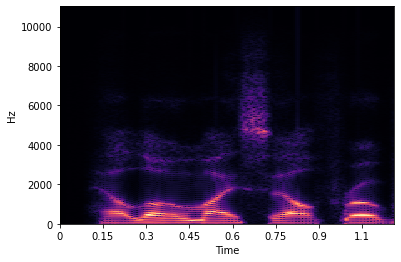

Reconstructed Audio:


Reconstructed Spectrogram:


c:\Users\HP\anaconda3\envs\env_3-6-13\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


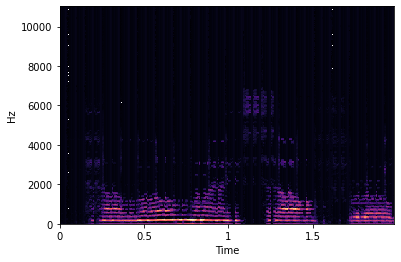

In [13]:
print("Original Audio:")
ipd.display(ipd.Audio(r_audio, rate=22050))

print("Spectrogram:")
librosa.display.specshow(np.sqrt(real), sr=22050, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.show()

print("Reconstructed Audio:")
ipd.display(ipd.Audio(p_audio, rate=22050))

print("Reconstructed Spectrogram:")
librosa.display.specshow(np.sqrt(pred), sr=22050, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.show()